<a href="https://colab.research.google.com/github/AnnieCRY/DS5230-project/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### load in processed data from previous step

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# move zip file to colab vm
! cp -r gdrive/My\ Drive/5230Project/processed_data ./

In [5]:
import pandas as pd
def modify_labels(path):
    csv_file = path + "/labels_BeeNotBee_th0.csv"
    labels_BeeNotBee_th0 = pd.read_csv(csv_file, index_col=0)

    def add_new_labels(df):
        labels_l=[]
        for x in df['label_strength']:
            if x>0.95:
                labels_l.append('nobee') 
            elif x==0:
                labels_l.append('bee') 
            else:
                labels_l.append('unknown') 
        df['label']=labels_l
        return df
    
    labels_BeeNotBee_th0=add_new_labels(labels_BeeNotBee_th0)
    labels_BeeNotBee_th0.to_csv(csv_file, index=False)

In [6]:
modify_labels('/content/processed_data/dataset_BeeNoBee_5sec')

In [7]:
# download the supporting files from github
! rm -rf Audio_based_identification_beehive_states/
! git clone https://github.com/Tonyz4516/Audio_based_identification_beehive_states.git

Cloning into 'Audio_based_identification_beehive_states'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (118/118), 69.02 KiB | 3.45 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [8]:
! mv Audio_based_identification_beehive_states/Bee_NotBee_classification/* ./


# PCA & TSNE

In [ ]:
! pip install muda

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from info import i, printb, printr, printp, print
from utils import load_audioFiles_saves_segments, write_Statelabels_from_beeNotBeelabels, get_uniqueHives_names_from_File, split_samples_byHive, get_samples_id_perSet, get_features_from_samples, labels2binary


In [10]:
block_size = 5
path_workingFolder = '/content/processed_data/dataset_BeeNoBee_'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
labels2read = 'labels_BeeNotBee_th0'
feature = 'MFCCs20'

In [11]:
# Feature extraction: 
# remember to un-comment the 3 lines about normalization in utils.get_features_from_samples
sample_ids_test, sample_ids_train, sample_ids_val = get_samples_id_perSet(path_workingFolder+'split_random_0.json') 
    
X_train = get_features_from_samples(path_workingFolder, sample_ids_train, 'MFCCs20', 'NO', 1)
X_val = get_features_from_samples(path_workingFolder, sample_ids_val, 'MFCCs20', 'NO', 1)
X_test = get_features_from_samples(path_workingFolder, sample_ids_test, 'MFCCs20', 'NO', 1)
    
# labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
# Y_train= labels2binary('nobee', labels_train)
    
# labels_val = get_GT_labels_fromFiles(path_workingFolder, sample_ids_val, labels2read)
# Y_val= labels2binary('nobee', labels_val)
    
# labels_test = get_GT_labels_fromFiles(path_workingFolder, sample_ids_test, labels2read)
# Y_test= labels2binary('nobee', labels_test)

In [12]:
def get_GT_labels_fromFiles(path_labels, sample_ids, labels2read) : #labels2read =  name of the label file
    labels = []
    fileAsdict={}
    
    with open(path_labels + labels2read+'.csv', 'r') as labfile:
        csvreader = csv.reader(labfile, delimiter=',')    
        for row in csvreader:
            if not row[0] == 'sample_name':
                fileAsdict[row[0]]=row[-1]   # row[-1] = '/missing queen/active' or 'bee/nobee'
                 
    for sample in sample_ids:
        labels.append(fileAsdict[sample[0:-4]])  #remove .wav extension

    return labels

In [13]:
labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
Y_train = labels_train

In [14]:
# 2-component PCA:
pca = PCA(n_components = 2)

pca = PCA(n_components = 2).fit_transform(X_train)

pca_df = pd.DataFrame(data = pca, columns = ['component1', 'component2'])

pca_df = pd.concat([pca_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)

Text(0.5, 1.0, 'True label')

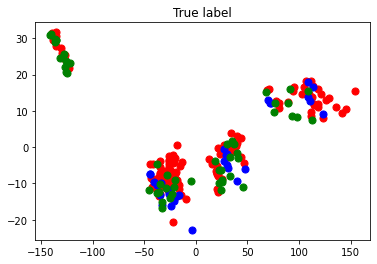

In [16]:
# 2-component PCA visualization:
plt.scatter(pca_df[pca_df['label']=='bee'].iloc[:,0], pca_df[pca_df['label']=='bee'].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pca_df[pca_df['label']=='nobee'].iloc[:,0], pca_df[pca_df['label']=='nobee'].iloc[:,1], c='b', s=50, cmap='viridis')
plt.scatter(pca_df[pca_df['label']=='unknown'].iloc[:,0], pca_df[pca_df['label']=='unknown'].iloc[:,1], c='g', s=50, cmap='viridis')

plt.title("True label")

Text(0.5, 1.0, 'True label')

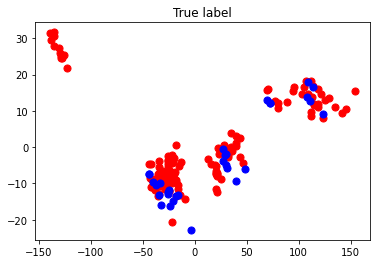

In [17]:
plt.scatter(pca_df[pca_df['label']=='bee'].iloc[:,0], pca_df[pca_df['label']=='bee'].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pca_df[pca_df['label']=='nobee'].iloc[:,0], pca_df[pca_df['label']=='nobee'].iloc[:,1], c='b', s=50, cmap='viridis')

plt.title("True label")

In [19]:
# 3-component PCA:
pca3 = PCA(n_components = 3)

pca3 = PCA(n_components = 3).fit_transform(X_train)

pca3_df = pd.DataFrame(data = pca3, columns = ['PC1', 'PC2', 'PC3'])

pca3_df = pd.concat([pca3_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)

In [21]:
# 3-component PCA visualization:
import plotly.express as px
fig = px.scatter_3d(pca3_df, x='PC1', y='PC2', z='PC3',color='label')
fig.show()

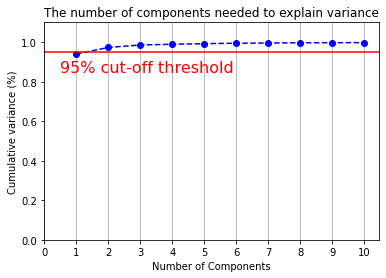

In [22]:
# get optimal number of components for PCA
pca = PCA().fit(X_train)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_[0:10])

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [23]:
# TSNE:
tsne = TSNE(n_components=2).fit_transform(X_train)

tsne_df = pd.DataFrame(data = tsne, columns = ['component1', 'component2'])

tsne_df = pd.concat([tsne_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)

Text(0.5, 1.0, 'True label')

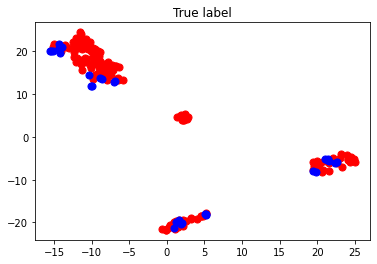

In [24]:
# TSNE visualization
plt.scatter(tsne_df[tsne_df['label']=='bee'].iloc[:,0], tsne_df[tsne_df['label']=='bee'].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(tsne_df[tsne_df['label']=='nobee'].iloc[:,0], tsne_df[tsne_df['label']=='nobee'].iloc[:,1], c='b', s=50, cmap='viridis')

plt.title("True label")
